In [18]:
from dataclasses import dataclass
import json
import dpath
from typing import List, Dict
import pandas as pd
import math

def open_results_file(filepath: str):
    with open(filepath) as f:
        data = json.loads(f.read())
    return data

def get_words_from_results(data: Dict):
    words = []
    for _, word in dpath.search(
        data,
        'responses/*/fullTextAnnotation/pages/*/blocks/*/paragraphs/*/words',yielded=True):
        words.append(word)
    return words

def get_tokens_from_words(results: List):
    tokens = []
    for words in results:
        for word in words:
            verts = word['boundingBox']['normalizedVertices']
            left, top = verts[0]['x'], verts[0]['y']
            right, bottom = verts[2]['x'], verts[2]['y']
            rect = [left,top,right,bottom]
            tokens.append(Token(rect, word['symbols'], word['confidence']))
    return Tokens(tokens)


class Token:
    def __init__(self, rectangle:List, symbols:List, confidence:float) -> None:
        self.rectangle = rectangle
        self.symbols = symbols
        self.confidence = confidence
        self.left = self.rectangle[0]
        self.top = 1-self.rectangle[1]
        self.right = self.rectangle[2]
        self.bottom = 1-self.rectangle[3]
    
    @property
    def text(self) -> str:
        return ''.join(char.get('text',' ') for char in self.symbols)

    @property
    def height(self) -> float:
        return self.top-self.bottom
    
    @property
    def length(self) -> float:
        return self.right-self.left

    def __repr__(self):
        return f'Y:{self.top:.3f} X:{self.left:.3f} ---- "{self.text}" ({self.confidence:.02f})'

class Tokens:
    
    def __init__(self, tokens: list) -> None:
        self.tokens=tokens

    truncate = 3
    epsilon = 0.007
    

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self.tokens):
            raise StopIteration
        value = self.tokens[self.index]
        self.index += 1
        return value

    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, index):
        return self.tokens[index]

    def __repr__(self):
        return '\n'.join(str(token) for token in self.tokens)

    @property
    def sorted_tokens(self) -> list:
        return sorted(
            self.tokens,
            key=lambda token: (-token.top, token.left),
        )

    def truncate_values(self, values: list, truncate: int):
        return [round(value, truncate) for value in values]

    def get_all_values(self, attribute: str):
        assert attribute in ['top', 'left', 'right', 'bottom'], 'Invalid attribute name'
        return [getattr(token, attribute) for token in self.tokens]
    
    @property
    def lines(self):
        new_line, lines = [], []
        prev_y = math.inf
        for token in self.sorted_tokens:
            is_new_line = bool(abs(token.top - prev_y) > self.epsilon)
            if is_new_line:
                lines.append(new_line)
                new_line=[]
                prev_y = token.top
            new_line.append(token)
            new_line.sort(key=lambda token: token.left)
        lines.append(new_line)
        return lines
    
    @property
    def columns(self):
        lefts = self.get_all_values('left')
        ...


   





tokens = get_tokens_from_words(get_words_from_results(open_results_file('pag9_d.json')))

tokens.lines



[[],
 [Y:0.964 X:0.513 ---- "8" (0.96)],
 [Y:0.929 X:0.133 ---- "Receita" (0.99),
  Y:0.929 X:0.267 ---- "do" (0.99),
  Y:0.929 X:0.313 ---- "Imperio" (0.99),
  Y:0.929 X:0.449 ---- "no" (0.99),
  Y:0.929 X:0.496 ---- "exercicio" (0.94),
  Y:0.929 X:0.659 ---- "de" (0.99),
  Y:0.929 X:0.706 ---- "1848-1849" (0.87),
  Y:0.929 X:0.908 ---- "." (0.98)],
 [Y:0.879 X:0.319 ---- "DENOMINAÇÃO" (0.94),
  Y:0.879 X:0.415 ---- "DAS" (0.96),
  Y:0.879 X:0.444 ---- "RENDAS" (0.94),
  Y:0.879 X:0.492 ---- "." (0.90),
  Y:0.878 X:0.703 ---- "ARRECADADA" (0.96),
  Y:0.876 X:0.787 ---- "." (0.98),
  Y:0.875 X:0.850 ---- "POR" (0.91)],
 [Y:0.865 X:0.824 ---- "ARRECADAR" (0.94), Y:0.865 X:0.897 ---- "." (0.98)],
 [Y:0.836 X:0.353 ---- "RENDA" (0.97),
  Y:0.836 X:0.410 ---- "GERAL" (0.98),
  Y:0.836 X:0.461 ---- "." (0.94)],
 [Y:0.812 X:0.371 ---- "ORDINARIA" (0.95), Y:0.812 X:0.440 ---- "." (0.78)],
 [Y:0.792 X:0.370 ---- "Importação" (0.94), Y:0.792 X:0.440 ---- "." (0.89)],
 [Y:0.772 X:0.131 ---- "Dir

In [135]:
intervals = []
HEADER_HEIGHT=0.015
MAX_OFFSET = 0.2
for line in tokens.lines:
    for token in line:
        if token.height < HEADER_HEIGHT and line[0].left < MAX_OFFSET:
            print(token)
            intervals.append(pd.Interval(token.left, token.right))
intervals.sort(key=lambda interval: interval.left)


Y:0.772 X:0.131 ---- "Direitos" (1.00)
Y:0.771 X:0.188 ---- "de" (1.00)
Y:0.771 X:0.212 ---- "consumo" (0.98)
Y:0.770 X:0.272 ---- ".." (0.99)
Y:0.771 X:0.692 ---- "14.720.8860614" (0.90)
Y:0.760 X:0.129 ---- "Ditos" (0.99)
Y:0.760 X:0.170 ---- "de" (0.99)
Y:0.760 X:0.192 ---- "1" (0.93)
Y:0.760 X:0.205 ---- "por" (0.99)
Y:0.760 X:0.235 ---- "cento" (0.99)
Y:0.759 X:0.276 ---- "de" (1.00)
Y:0.760 X:0.299 ---- "reexportação" (0.98)
Y:0.759 X:0.380 ---- "." (0.98)
Y:0.754 X:0.719 ---- "62.547" (0.97)
Y:0.749 X:0.129 ---- "Ditos" (0.99)
Y:0.749 X:0.170 ---- "de" (0.99)
Y:0.749 X:0.192 ---- "1" (0.96)
Y:0.749 X:0.205 ---- "por" (0.99)
Y:0.749 X:0.235 ---- "cento" (1.00)
Y:0.748 X:0.276 ---- "de" (1.00)
Y:0.748 X:0.299 ---- "baldeação" (0.96)
Y:0.753 X:0.778 ---- "717" (0.99)
Y:0.738 X:0.129 ---- "Ditos" (0.99)
Y:0.738 X:0.170 ---- "de" (0.99)
Y:0.738 X:0.192 ---- "5" (0.56)
Y:0.738 X:0.205 ---- "por" (0.99)
Y:0.738 X:0.235 ---- "cento" (0.99)
Y:0.738 X:0.276 ---- "de" (1.00)
Y:0.738 X:0.29

In [136]:
df = pd.DataFrame( 
    {'left':[i.left for i in intervals],
    'right':[i.right for i in intervals]},
    )

In [103]:
df['len'] = df['right'] - df['left']

0      0.068908
1      0.026891
2      0.030252
3      0.065546
4      0.082353
         ...   
390    0.062185
391    0.058824
392    0.058824
393    0.050420
394    0.006723
Name: len, Length: 395, dtype: float64

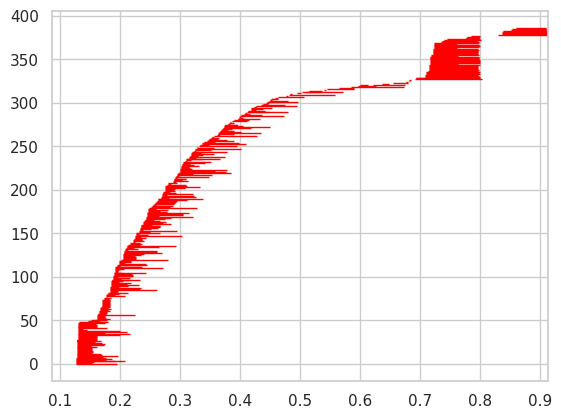

In [144]:


import matplotlib.pyplot as plt

def plot_intervals(intervals):

    df = pd.DataFrame( 
        {'left':[i.left for i in intervals],
        'right':[i.right for i in intervals]},
        )
    start = df['right']
    end = df['left']
    width = end-start
    fig, ax = plt.subplots()
    ax.barh(width=width, left=start, height=0.005, y=df.index, color='red',edgecolor='red')
    plt.show()

plot_intervals(intervals)

In [150]:
gaps = []
temp_interval, intervals = intervals[0], intervals[1:]
for index, interval in enumerate(intervals):
    if index and interval.left > temp_interval.right:
        temp_interval = interval
        gaps.append(pd.Interval(left=interval.left, right=interval.right))
        print(temp_interval.left,interval.right)
    else:
        if interval.right > temp_interval.right:
            temp_interval=pd.Interval(temp_interval.left, interval.right)

0.68235296 0.68403363
0.692437 0.80336136
0.8302521 0.91260505


In [151]:
gaps

[Interval(0.68235296, 0.68403363, closed='right'),
 Interval(0.692437, 0.80336136, closed='right'),
 Interval(0.8302521, 0.91260505, closed='right')]

In [66]:
def overlap(start1, end1, start2, end2):
    """how much does the range (start1, end1) overlap with (start2, end2)"""
    return max(max((end2-start1), 0) - max((end2-end1), 0) - max((start2-start1), 0), 0)

Interval(0.90756303, 0.9142857, closed='right')